# Tutorial: Using the OKLAD (Oklahoma labeled AI dataset)) Dataset with SeisBench

**Author:** Hongyu Xiao @ OU

**Last Updated:** 20251117


## Loading a Dataset

SeisBench provides access to several pre-compiled datasets. These are curated collections of seismic waveforms and associated metadata, ready for use in machine learning applications. You can find a list of available datasets in the [SeisBench documentation](https://seisbench.readthedocs.io/en/stable/pages/benchmark_datasets.html).

Here, we first will load the "DummyDataset" dataset, which is a sample dataset in seismology. We specify a `sampling_rate` of 100 Hz, which means the waveforms will be resampled to this frequency if they are not already.

In [1]:
import seisbench
import seisbench.data as sbd

data = sbd.DummyDataset(sampling_rate=100)
train, dev, test = data.train_dev_test()

2025-11-18 16:07:32,831 | seisbench | WARNING | Component order not specified, defaulting to 'ZNE'.


When running this command for the first time, the dataset is downloaded. All downloaded data is stored in the SeisBench cache. 

The location of the cache defaults to `~/.seisbench`, but can be set using the environment variable `SEISBENCH_CACHE_ROOT`. 

Let's inspect the cache. Depending which commands where used before, it contains at least the directory `datasets`. 

Inside this directory, each locally available dataset has its own folder. If we look into the folder `dummydataset`, we find two relevant files `metadata.csv` and `waveforms.hdf5`, containing the metadata and the waveforms.


In [2]:
# Enhanced, more explanatory cache / datasets summary
# (Uses variables and helpers defined elsewhere in this notebook:
#  - cache_root (Path)
#  - datasets_dir (Path)
#  - hr_size(n) -> human readable size
#  - datetime)
print("SeisBench cache summary")
print("=" * 40)
print(f"Cache root: {cache_root}")
print()

# Top-level entries with type, size and modification time
try:
    top_entries = sorted(cache_root.iterdir())
    print(f"Top-level entries ({len(top_entries)}):")
    for p in top_entries:
        try:
            st = p.stat()
            size = hr_size(st.st_size)
            mtime = datetime.fromtimestamp(st.st_mtime).isoformat(sep=' ', timespec='seconds')
            typ = "dir" if p.is_dir() else "file"
            print(f"  - {p.name:30} {size:8}  {typ:4}  modified: {mtime}")
        except Exception as e:
            print(f"  - {p.name:30} (unable to stat: {e})")
except Exception as e:
    print("Could not list cache root:", e)
print()

# Datasets folder overview
if datasets_dir.exists() and datasets_dir.is_dir():
    ds_list = sorted([p for p in datasets_dir.iterdir() if p.is_dir()])
    print(f"Datasets folder: {datasets_dir}  ({len(ds_list)} datasets)")
    for d in ds_list:
        print(f"\nDataset: {d.name}")
        print(f"  Path: {d}")
        try:
            items = sorted(d.iterdir())
            print(f"  Contains {len(items)} item(s):")
            for it in items:
                try:
                    st = it.stat()
                    size = hr_size(st.st_size)
                    mtime = datetime.fromtimestamp(st.st_mtime).isoformat(sep=' ', timespec='seconds')
                    typ = "dir" if it.is_dir() else "file"
                    # Add a short hint for commonly expected dataset files
                    hint = ""
                    nm = it.name.lower()
                    if nm.endswith(".csv"):
                        hint = " (metadata CSV)"
                    elif nm.endswith(".hdf5") or nm.endswith(".h5"):
                        hint = " (waveforms HDF5)"
                    elif nm.endswith(".py"):
                        hint = " (script)"
                    print(f"    - {it.name:30} {size:8}  {typ:4}  modified: {mtime}{hint}")
                except Exception as e:
                    print(f"    - {it.name:30} (unable to stat: {e})")
        except Exception as e:
            print(f"  Could not inspect dataset contents: {e}")
else:
    print("No 'datasets' folder found in cache.")

SeisBench cache summary


NameError: name 'cache_root' is not defined

## Explanation of SeisBench cache summary

- Why this is useful:
    - Quick inspection of locally available datasets and their on-disk footprint.
    - Helps identify missing or unexpected files and confirms where large files (e.g. HDF5 waveforms) reside.

## What does a dataset contain?

In [42]:
from pathlib import Path

# Ensure we use metadata CSV and HDF5 from the same dataset directory.
# Relies on existing notebook variables: datasets_dir, meta_path, hdf5_path, df, pd, h5py


# find dataset dirs that contain both metadata.csv and waveforms.hdf5
cand_dirs = []
for d in sorted(datasets_dir.iterdir()):
    if d.is_dir():
        if (d / "metadata.csv").exists() and (d / "waveforms.hdf5").exists():
            cand_dirs.append(d)

if not cand_dirs:
    raise FileNotFoundError("No dataset directory found containing both metadata.csv and waveforms.hdf5 under datasets_dir")

# prefer the dataset that already matches meta_path (if set), otherwise pick first candidate
selected = None
if 'meta_path' in globals():
    mp_parent = Path(meta_path).parent if meta_path is not None else None
    for d in cand_dirs:
        if mp_parent is not None and d.samefile(mp_parent):
            selected = d
            break
if selected is None:
    selected = cand_dirs[0]

# set paths to ensure they come from the same dataset
meta_path = selected / "metadata.csv"
hdf5_path = selected / "waveforms.hdf5"

print("Using dataset:", selected.name)
print("Metadata CSV:", meta_path)
print("HDF5:", hdf5_path)
print()

# (Re)load metadata into df to guarantee it matches meta_path
df = pd.read_csv(meta_path)

# Compact display of metadata
print("Rows, columns:", df.shape)
print("Column names (first 8):", df.columns[:8].tolist())
print("\nFirst 3 rows (first 6 columns):")
print(df.iloc[:3, :6].to_string(index=False))

# Inspect HDF5: top-level keys and one example dataset (path, shape, dtype)
try:
    with h5py.File(hdf5_path, 'r') as h:
        top_keys = list(h.keys())
        print("\nTop-level keys:", top_keys)

        def find_first_dataset(g):
            for k in g.keys():
                obj = g[k]
                if isinstance(obj, h5py.Dataset):
                    return obj
                if isinstance(obj, h5py.Group):
                    res = find_first_dataset(obj)
                    if res is not None:
                        return res
            return None

        ds = find_first_dataset(h)
        if ds is not None:
            print("Example dataset:", ds.name)
            print("  shape:", ds.shape, "dtype:", ds.dtype)
            print("  -> Waveform arrays referenced by metadata (e.g. trace name / id).")
        else:
            print("No dataset found inside HDF5.")
except Exception as e:
    print("Could not open HDF5:", e)


Using dataset: dummydataset
Metadata CSV: /Users/hongyuxiao/.seisbench/datasets/dummydataset/metadata.csv
HDF5: /Users/hongyuxiao/.seisbench/datasets/dummydataset/waveforms.hdf5

Rows, columns: (100, 20)
Column names (first 8): ['trace_start_time', 'source_latitude_deg', 'source_longitude_deg', 'source_depth_km', 'source_event_category', 'source_magnitude', 'source_magnitude_uncertainty', 'source_magnitude2']

First 3 rows (first 6 columns):
      trace_start_time  source_latitude_deg  source_longitude_deg  source_depth_km source_event_category  source_magnitude
2007/01/01 01:42:45.08            -20.43802             -69.27681            83.18                    ID             1.353
2007/01/01 02:41:13.75            -21.64059             -68.41443           118.38                    ID             1.981
2007/01/01 03:50:29.27            -21.84637             -68.53904           111.82                    ID             2.719

Top-level keys: ['data', 'data_format']
Example dataset: /dat

Each dataset consists of waveforms and the associated metadata.

Let's first inspect the metadata. It is represented by a pandas DataFrame and lists for each trace different attributes, describing properties of the source, the trace, the station and possibly the path. When loading a dataset, only the metadata is loaded into memory. 

The waveforms are loaded on demand.

In [43]:
data.metadata

,index,trace_start_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_event_category,source_magnitude,source_magnitude_uncertainty,source_magnitude2,source_magnitude_uncertainty2,...,station_latitude_deg,station_longitude_deg,station_elevation_m,source_magnitude_type,source_magnitude_type2,split,trace_name_original,trace_chunk,trace_sampling_rate_hz,trace_component_order
0,0,2007/01/01 01:42:45.08,-20.43802,-69.27681,83.18,ID,1.353,0.014,1.426,0.011,...,-21.04323,-69.4874,900.0,MA,ML,train,2007_01_01 01_42_45_08,,20,ZNE
1,1,2007/01/01 02:41:13.75,-21.64059,-68.41443,118.38,ID,1.981,0.020,2.027,0.023,...,-21.04323,-69.4874,900.0,MA,ML,train,2007_01_01 02_41_13_75,,20,ZNE
2,2,2007/01/01 03:50:29.27,-21.84637,-68.53904,111.82,ID,2.719,0.024,2.811,0.026,...,-21.04323,-69.4874,900.0,MA,ML,train,2007_01_01 03_50_29_27,,20,ZNE
3,3,2007/01/01 05:40:02.55,-21.23950,-70.05063,34.95,UP,2.169,0.020,2.269,0.020,...,-21.04323,-69.4874,900.0,MA,ML,train,2007_01_01 05_40_02_55,,20,ZNE
4,4,2007/01/01 05:52:18.43,-21.81511,-68.65773,106.69,ID,2.028,0.021,2.080,0.024,...,-21.04323,-69.4874,900.0,MA,ML,train,2007_01_01 05_52_18_43,,20,ZNE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,2007/01/07 05:19:53.63,-21.02248,-68.96970,109.05,ID,1.464,0.016,1.513,0.021,...,-21.04323,-69.4874,900.0,MA,ML,test,2007_01_07 05_19_53_63,,20,ZNE
96,96,2007/01/07 05:25:44.43,-20.06507,-69.15500,93.64,ID,1.606,0.024,1.660,0.026,...,-21.04323,-69.4874,900.0,MA,ML,test,2007_01_07 05_25_44_43,,20,ZNE
97,97,2007/01/07 06:37:03.33,-21.13000,-68.90223,110.59,ID,1.530,0.012,1.574,0.013,...,-21.04323,-69.4874,900.0,MA,ML,test,2007_01_07 06_37_03_33,,20,ZNE
98,98,2007/01/07 06:39:20.08,-21.26966,-68.73751,120.06,ID,3.514,0.035,3.584,0.032,...,-21.04323,-69.4874,900.0,MA,ML,test,2007_01_07 06_39_20_08,,20,ZNE


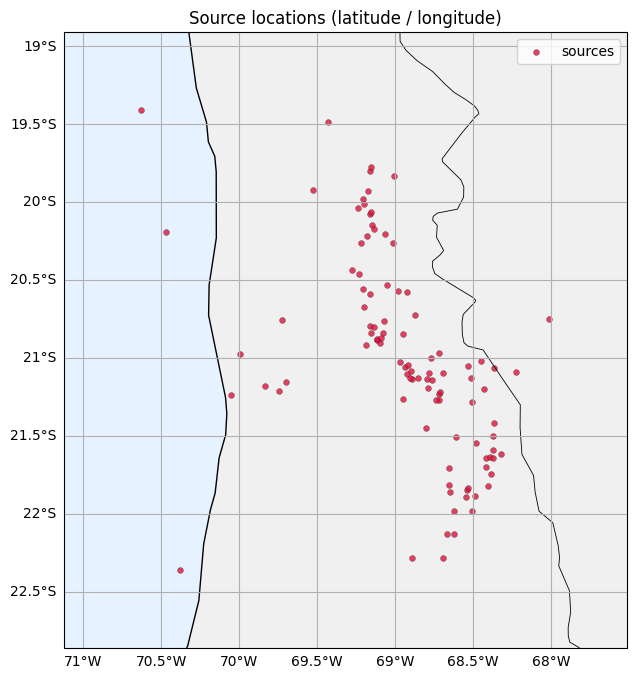

In [47]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# get lon/lat from existing dataframe
lon = df['source_longitude_deg'].values
lat = df['source_latitude_deg'].values

# compute extent with a small margin
lon_min, lon_max = float(lon.min()), float(lon.max())
lat_min, lat_max = float(lat.min()), float(lat.max())
lon_rng = max(0.5, 0.1 * (lon_max - lon_min))
lat_rng = max(0.5, 0.1 * (lat_max - lat_min))
extent = [lon_min - lon_rng, lon_max + lon_rng, lat_min - lat_rng, lat_max + lat_rng]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# base features
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#f0f0f0')
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='#e6f2ff')
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.6)

# rivers (use NaturalEarth high-res if available)
try:
    rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',
                                          edgecolor='royalblue', facecolor='none')
    ax.add_feature(rivers, linewidth=0.6)
except Exception:
    # fallback to built-in rivers feature
    ax.add_feature(cfeature.RIVERS, edgecolor='royalblue', linewidth=0.6)

# plot sources
sc = ax.scatter(lon, lat, s=18, c='crimson', alpha=0.8, edgecolor='k', linewidth=0.2,
                transform=ccrs.PlateCarree(), label='sources')

ax.set_extent(extent, crs=ccrs.PlateCarree())

# gridlines and labels
gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False

ax.set_title("Source locations (latitude / longitude)")
ax.legend(loc='upper right')

plt.show()

In [52]:
print("Citation:", data.citation)
print("License:", data.license)

Citation: Münchmeyer, Jannes; Bindi, Dino; Sippl, Christian; Leser, Ulf; Tilmann, Frederik (2019): Magnitude scales, attenuation models and feature matrices for the IPOC catalog. V. 1.0. GFZ Data Services. https://doi.org/10.5880/GFZ.2.4.2019.004
License: None
